In [1]:
%env CUDA_VISIBLE_DEVICES=8

env: CUDA_VISIBLE_DEVICES=8


In [2]:
import compressai
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
net = compressai.zoo.cheng2020_attn(6, "mse", pretrained=True)

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-6-730501f2.pth.tar" to /home/xyhang/.cache/torch/hub/checkpoints/cheng2020_attn-mse-6-730501f2.pth.tar
100%|██████████| 121M/121M [00:46<00:00, 2.75MB/s] 


In [4]:
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target, lmbda):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        likelihoods = output['likelihoods']
        bits_y = -torch.log2(likelihoods['y'])
        bits_z = -torch.log2(likelihoods['z']) if 'z' in likelihoods else torch.tensor(0.)

        out['bpp_y_loss'] = torch.sum(bits_y) / num_pixels
        out['bpp_z_loss'] = torch.sum(bits_z) / num_pixels
        out['bpp_loss'] = out['bpp_y_loss'] + out["bpp_z_loss"]

        out["mse_loss"] = torch.mean((output["x_hat"] - target) ** 2, dim=(1, 2, 3))
        dloss = 255**2 * torch.mean(torch.mul(lmbda, out["mse_loss"]))
        out["mse_loss"] = torch.mean(out["mse_loss"])
        out["loss"] = dloss + out["bpp_loss"]
        out["psnr_loss"] = -10 * torch.log10(out["mse_loss"])

        return out

In [5]:
import math

def est_psnr(psnr, epsilon):
    mse = math.pow(10, -psnr/10)
    mse2 = mse + epsilon ** 2 + 2 * epsilon * math.sqrt(mse)
    psnr2 = -10 * math.log10(mse2)
    return psnr2

In [6]:
print(est_psnr(33.8,0.001))

33.384673379199356


In [7]:
import math

def normalize_l2(x, delta):
    mx = x.square().mean()
    if mx > 0.:
        mx2 = torch.minimum(mx, torch.tensor(delta))
        x = x * (mx2 / mx).sqrt()
    return x

def normalize_l0(x, delta):
    x = x.clamp(torch.tensor(-delta,device=x.device), torch.tensor(delta,device=x.device))
    return x

def cosine_decay(init_lr, step, num_steps, alpha):
    t = step / num_steps
    a = (1. + math.cos(t * math.pi)) * init_lr / 2
    return alpha * init_lr + (1-alpha) * a


def find_image(net, img, num_steps=100, init_lr=1e-3, delta=.005):
    img = img.detach().cuda()
    # input = nn.Parameter(img.clone().detach().unsqueeze(0))
    noise = nn.Parameter(torch.zeros_like(img).unsqueeze(0))
    # print(input)
    net = net.cuda()
    optimizer = torch.optim.Adamax([noise], init_lr)
    net.train()
    criterion = RateDistortionLoss()
    for i in range(num_steps):
        optimizer.param_groups[0]['lr'] = cosine_decay(init_lr, i, num_steps, 0.01)

        noise_normed = normalize_l0(noise, delta)
        input2 = torch.clamp(noise_normed + img.unsqueeze(0), 0., 1.)
        out = net(input2)
        out["x_hat"] = torch.clamp(out["x_hat"], 0., 1.)
        out_criterion = criterion(out, input2, 0.05)
        loss_rd = - out_criterion['loss']
        loss = loss_rd

        if i % 10 == 0:
            print(f"Step: {i} "
              f"Loss: {loss.detach().cpu()} "
              f"PSNR_rd: {out_criterion['psnr_loss'].detach().cpu()} " 
              f"BPP_rd: {out_criterion['bpp_loss'].detach().cpu()} ")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    noise_normed = normalize_l0(noise, delta)
    output = (noise_normed[0] + img).clamp(0., 1.).detach().cpu()
    output = torch.round(output * 255) / 255.
    return output

In [8]:
def l2_noise_like(x, l2):
    stepsize = torch.rand(()) * l2
    noise = (torch.rand_like(x) - 0.5)
    noise = stepsize * (noise / torch.sqrt(noise.square().sum()))
    return noise

@torch.no_grad()
def find_image_sa(net, img, initial=None, num_steps=10000, stepsize=5, T0=0.01, epsilon=3./255):
    # Use simulated annealing to find an example

    criterion = RateDistortionLoss()
    def evaluate(net, x):
        x = x.unsqueeze(0)
        out = net(x)
        out["x_hat"] = torch.clamp(out["x_hat"], 0., 1.)
        out_criterion = criterion(out, x, 0.05)
        loss_rd = - out_criterion['loss']
        loss = loss_rd
        return loss, out_criterion

    img = img.detach().cuda()
    net = net.cuda()
    net.eval()

    if initial is None:
        initial = img.clone()

    x = initial.cuda()
    x_loss, x_criterion = evaluate(net, x)
    min_x = x
    min_loss = x_loss
    min_criterion = x_criterion
    for i in range(num_steps):
        k = (num_steps - i) / num_steps
        T = T0 * k

        step = l2_noise_like(x, stepsize * k)
        nxt = x + step
        nxt = torch.clamp(nxt - img, -epsilon, epsilon) + img
        nxt = torch.clamp(nxt, 0., 1.)
        
        loss, out_criterion = evaluate(net, nxt)

        if loss < x_loss:
            x_loss = loss
            x = nxt
            x_criterion = out_criterion
        else:
            P = torch.exp(x_loss - loss) ** (1. / T)
            p = torch.rand(())
            if p < P:
                x = nxt
                x_loss = loss
                x_criterion = out_criterion
        
        if loss < min_loss:
            min_loss = loss
            min_x = x
            min_criterion = out_criterion

        if i % 10 == 0:
            print(f"Step: {i} "
              f"x_Loss: {x_loss.detach().cpu()} "
              f"x_PSNR: {x_criterion['psnr_loss'].detach().cpu()} " 
              f"x_BPP: {x_criterion['bpp_loss'].detach().cpu()} "
              f"best_Loss: {min_loss.detach().cpu()} "
              f"best_PSNR: {min_criterion['psnr_loss'].detach().cpu()} " 
              f"best_BPP: {min_criterion['bpp_loss'].detach().cpu()} ")
            
    output = min_x.clamp(0., 1.).detach().cpu()
    output = torch.round(output * 255) / 255.
    return output

In [9]:
from dataset import Kodak
ds = Kodak()
img = ds[1]

In [10]:
att = None
att = find_image(net, img, 1000, 1e-3, delta=3./255)
att_sa = find_image_sa(net, img, att)

Step: 0 Loss: -1.2437702417373657 PSNR_rd: 37.396018981933594 BPP_rd: 0.6515973210334778 
Step: 10 Loss: -1.655080795288086 PSNR_rd: 35.59531784057617 BPP_rd: 0.7586464881896973 
Step: 20 Loss: -2.0121777057647705 PSNR_rd: 34.49575424194336 BPP_rd: 0.8574619293212891 
Step: 30 Loss: -2.1300787925720215 PSNR_rd: 34.13089370727539 BPP_rd: 0.8741612434387207 
Step: 40 Loss: -2.193207263946533 PSNR_rd: 33.93134689331055 BPP_rd: 0.8782374858856201 
Step: 50 Loss: -2.2285494804382324 PSNR_rd: 33.81236267089844 BPP_rd: 0.8770548105239868 
Step: 60 Loss: -2.2615859508514404 PSNR_rd: 33.718597412109375 BPP_rd: 0.8805948495864868 
Step: 70 Loss: -2.2745120525360107 PSNR_rd: 33.67346954345703 BPP_rd: 0.8790961503982544 
Step: 80 Loss: -2.2864506244659424 PSNR_rd: 33.62734603881836 BPP_rd: 0.8761362433433533 
Step: 90 Loss: -2.2934391498565674 PSNR_rd: 33.613189697265625 BPP_rd: 0.8785211443901062 
Step: 100 Loss: -2.30427885055542 PSNR_rd: 33.58272171020508 BPP_rd: 0.879398763179779 
Step: 110 Lo

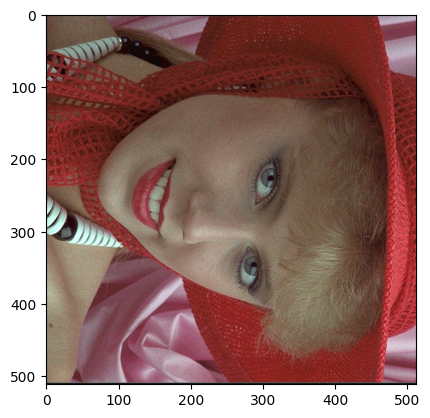

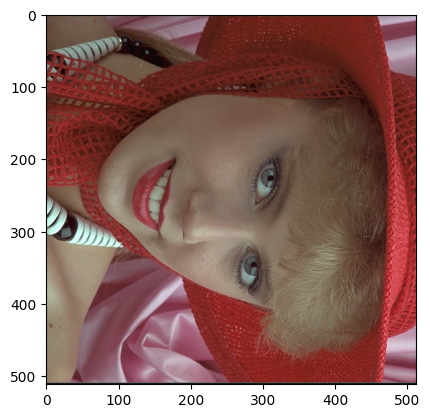

In [11]:
plt.imshow(att.clamp(0., 1.).detach().cpu().permute(1, 2, 0))
plt.show()
plt.imshow(img.detach().cpu().permute(1, 2, 0))

In [12]:
mse = torch.mean((att.clamp(0, 1) - img)**2)
psnr = -10*torch.log10(mse)
print(f"MSE: {mse:.8f}", mse, "PSNR: att-img", psnr)

MSE: 0.00013800 tensor(0.0001) PSNR: att-img tensor(38.6011)


In [13]:
def get_recon_bpp(net: nn.Module, img, training=False):
    net.train(training).cuda()
    input = img.cuda().unsqueeze(0).clamp(0., 1.)
    out_net = net(input)
    out_net['x_hat'] = out_net['x_hat'].clamp(0., 1.)
    recon_img = out_net['x_hat'].detach().cpu()[0]
    criterion = RateDistortionLoss()
    out_criterion = criterion(out_net, input, 0)
    bpp = out_criterion['bpp_loss'].detach().cpu()
    psnr = out_criterion['psnr_loss'].detach().cpu()
    return recon_img, bpp, psnr

In [14]:
recon_img, bpp_img, psnr_img = get_recon_bpp(net, img, False)
recon_att, bpp_att, psnr_att = get_recon_bpp(net, att, False)

In [15]:
print(bpp_img, bpp_att)
print(psnr_img, psnr_att)

tensor(0.5413) tensor(0.7809)
tensor(37.1806) tensor(33.3506)


In [16]:
torch.mean((att - recon_att) ** 2)

tensor(0.0005)

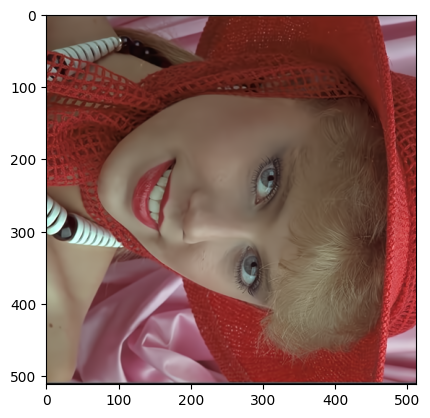

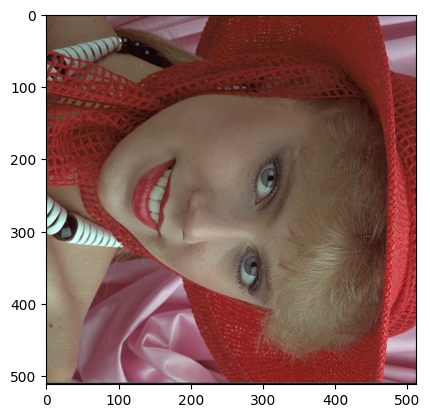

In [17]:
plt.imshow(recon_img.permute(1,2,0))
plt.show()
plt.imshow(recon_att.permute(1,2,0))

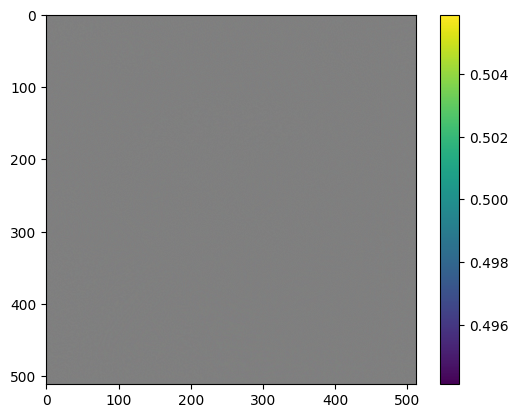

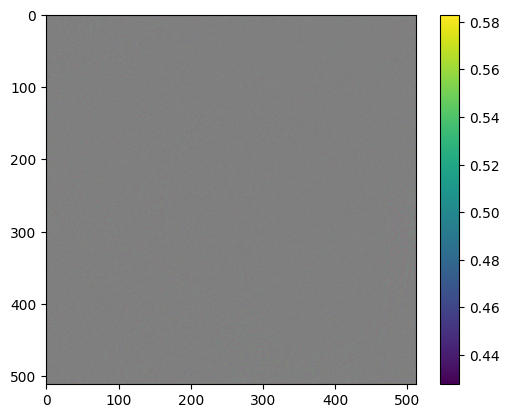

In [18]:
plt.imshow(0.5*(att - img + 1.).permute(1,2,0))
plt.colorbar()
plt.show()
plt.imshow(0.5*(att - recon_att + 1.).permute(1,2,0))
plt.colorbar()

In [19]:
net2 = compressai.zoo.bmshj2018_factorized(6, "mse", pretrained=True)

Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar" to /home/xyhang/.cache/torch/hub/checkpoints/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar
 72%|███████▏  | 19.7M/27.3M [00:20<00:07, 1.01MB/s]


KeyboardInterrupt: 

tensor(0.7153) tensor(0.7614)
tensor(36.5132) tensor(35.4991)


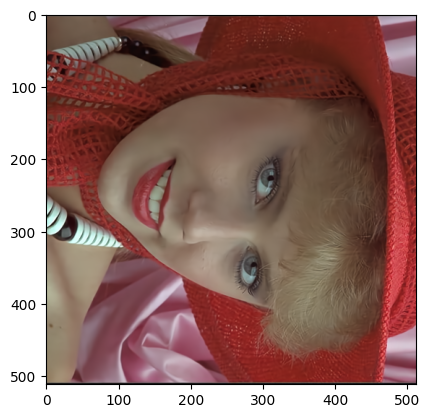

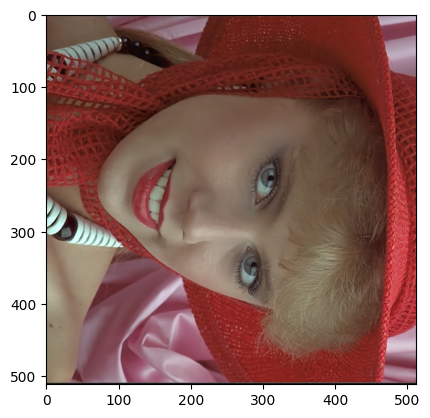

In [ ]:
recon_img2, bpp_img2, psnr_img2 = get_recon_bpp(net2, img)
recon_att2, bpp_att2, psnr_att2 = get_recon_bpp(net2, att)
print(bpp_img2, bpp_att2)
print(psnr_img2, psnr_att2)
plt.imshow(recon_img2.permute(1,2,0))
plt.show()
plt.imshow(recon_att2.permute(1,2,0))

In [ ]:
# View feature map

def get_bpp_map(net: nn.Module, img, training=False):
    net.train(training).cuda()
    input = img.cuda().unsqueeze(0).clamp(0., 1.)
    out_net = net(input)
    return out_net['likelihoods']['y'][0]

y_prob = get_bpp_map(net, img)
y_prob_att = get_bpp_map(net, att)

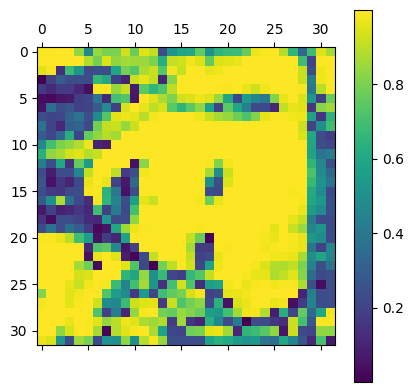

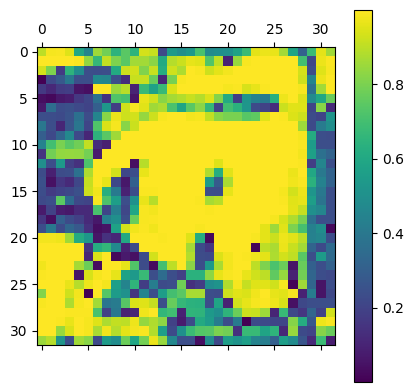

In [ ]:
def show_tensor(x, c):
    plt.matshow(x[c].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    plt.close()

show_tensor(y_prob, 0)
show_tensor(y_prob_att, 0)

In [ ]:
y_prob.mean()

tensor(0.7709, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
y_prob_att.mean()

tensor(0.7436, device='cuda:0', grad_fn=<MeanBackward0>)